In [1]:
# imports 
import kagglehub
import pandas as pd 
import numpy as np
import os 
from tensorflow import keras
import tensorflow as tf

/Users/aidaduong/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setting constant values!
img_height = 180
img_width = 180
batch_size = 32

# ensure reproducibility
keras.utils.set_random_seed(101)


In [3]:
# imports 
import kagglehub
import pandas as pd 
import numpy as np
import os 

# define and collect image paths and labels

# kaggle import 
path = kagglehub.dataset_download("syedalinaqvi/augmented-skin-conditions-image-dataset")
image_folder = os.path.join(path, "Skin_Conditions")
print("Image folder:", image_folder)
print("Subfolders (classes):", os.listdir(image_folder))

# create empty lists to hold image paths and labels
image_paths = []
labels = []

# iterate through each subfolder and collect image paths and labels
for label in sorted(os.listdir(image_folder)):
    label_folder = os.path.join(image_folder, label)

    if os.path.isdir(label_folder):
        for filename in os.listdir(label_folder):
            if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(label_folder, filename))
                labels.append(label)


Image folder: /Users/aidaduong/.cache/kagglehub/datasets/syedalinaqvi/augmented-skin-conditions-image-dataset/versions/1/Skin_Conditions
Subfolders (classes): ['Carcinoma', '.DS_Store', 'Keratosis', 'Acne', 'Eczema', 'Rosacea', 'Milia']


In [4]:
# create dataframe
df = pd.DataFrame({"image_path": image_paths, "labels": labels})
# remove rows w/ missing or invalid paths 
df = df[df["image_path"].apply(os.path.exists)]
df = df.drop_duplicates()

# # summary (to check if it matches up w/ what kaggle says)
# print(f"\nTotal images: {len(df)}")
# print("Images per class:")
# print(df["labels"].value_counts())


Total images: 2394
Images per class:
labels
Acne         399
Carcinoma    399
Eczema       399
Keratosis    399
Milia        399
Rosacea      399
Name: count, dtype: int64


In [13]:
# train model 

train_ds = tf.keras.utils.image_dataset_from_directory(
  image_folder,
  validation_split=0.2,
  subset="training",
  seed=101, 
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

Found 2394 files belonging to 6 classes.
Using 1916 files for training.


['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']

In [6]:
# validate model

val_ds = tf.keras.utils.image_dataset_from_directory(
  image_folder,
  validation_split=0.2,
  subset="validation",
  seed=101,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2394 files belonging to 6 classes.
Using 478 files for validation.


In [7]:
# use autotune to improve performance! 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# data augmentation to generate additional samples for training 
# reduce overfitting 

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height, img_width, 3),
                      seed = 101),
    layers.RandomRotation(0.1, seed = 101),
    layers.RandomZoom(0.1, seed = 101)
  ]
)

/Users/aidaduong/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
from tensorflow.keras.layers import BatchNormalization
# batchnormalization to normalize inputs for each layer -> make it more stable

num_classes = 6

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),
  
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


model.compile(
  optimizer= Adam(3e-5),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


2025-11-16 21:40:49.240605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 0.4285 - loss: 2.5704 - val_accuracy: 0.1569 - val_loss: 1.9012
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.5089 - loss: 1.7760 - val_accuracy: 0.1569 - val_loss: 2.1550
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.5621 - loss: 1.6132 - val_accuracy: 0.1632 - val_loss: 2.3874
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.5699 - loss: 1.5182 - val_accuracy: 0.1590 - val_loss: 2.6617
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 0.6033 - loss: 1.4293 - val_accuracy: 0.2071 - val_loss: 2.3681
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.6227 - loss: 1.3995 - val_accuracy: 0.2929 - val_loss: 2.0807
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.6409 - loss: 1.3187 - val_accuracy: 0.4121 - val_loss: 1.5652
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.6524 - loss: 1.2794 - val_accuracy: 0.516

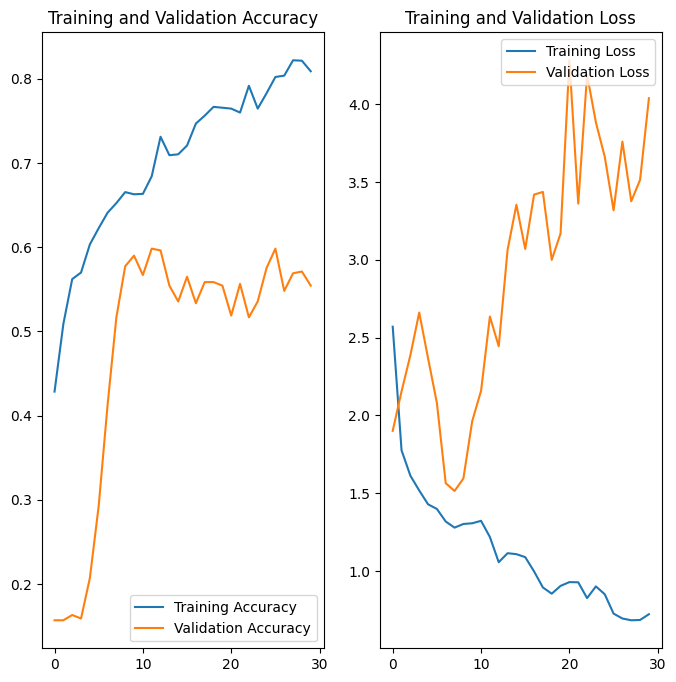

In [10]:
import matplotlib.pyplot as plt

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epoc)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
# val_loss, val_accuracy = model.evaluate(X_test, y_test)
# print(f"Final Validation Loss: {val_loss:.4f}")
# print(f"Final Validation Accuracy: {val_accuracy:.4f}")

val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5544 - loss: 4.0385
Final Validation Loss: 4.0385
Final Validation Accuracy: 0.5544


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# # labeling and predictions
# y_true = np.argmax(y_test, axis=1)
# y_pred_logits = model.predict(X_test)
# y_pred = np.argmax(y_pred_logits, axis=1)

# # classification report
# print(classification_report(
#     y_true, 
#     y_pred, 
#     target_names=le.classes_
# ))

# # confusion matrix
# cm = confusion_matrix(y_true, y_pred)
# print("Confusion Matrix:\n", cm)

# labeling and predictions
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
y_pred_logits = np.concatenate([model(x, training=False).numpy() for x, y in val_ds], axis=0)
y_pred = np.argmax(y_pred_logits, axis=1)

# classification report
print(classification_report(y_true, y_pred, target_names = class_names))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

2025-11-16 21:49:19.435814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

        Acne       0.28      0.22      0.24        74
   Carcinoma       0.50      0.08      0.14        84
      Eczema       0.18      0.81      0.29        80
   Keratosis       0.12      0.03      0.05        66
       Milia       0.00      0.00      0.00        87
     Rosacea       0.67      0.16      0.26        87

    accuracy                           0.22       478
   macro avg       0.29      0.22      0.16       478
weighted avg       0.30      0.22      0.17       478

Confusion Matrix:
 [[16  3 54  0  0  1]
 [ 5  7 64  4  1  3]
 [ 9  0 65  4  0  2]
 [ 7  0 56  2  0  1]
 [16  2 65  4  0  0]
 [ 4  2 65  2  0 14]]


2025-11-16 21:49:20.306730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


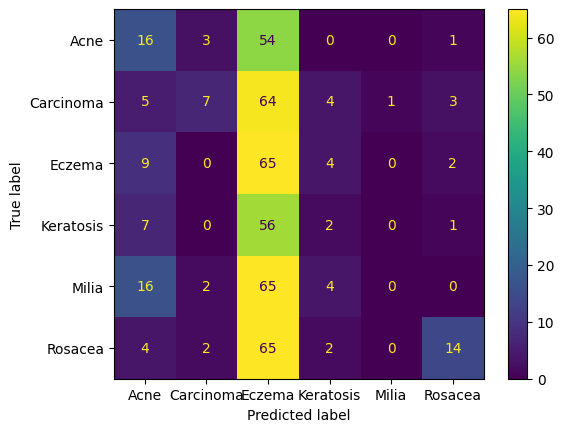

In [15]:
# confusion matrix visualization!

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm , display_labels=df["labels"].unique())
disp.plot()
plt.show()
# print("Confusion Matrix:\n", cm)

In [16]:
# keras.utils.set_random_seed(42)

# model = Sequential([
#     layers.Input(shape=(180,180,3)),
#     layers.Rescaling(1./255),
# ])

# model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
# model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(MaxPooling2D(2,2))
# model.add(Dropout(0.3))

# model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(Dropout(0.3))

# model.add(MaxPooling2D(2,2))
# model.add(Dropout(0.3))

# model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(MaxPooling2D(2,2))
# model.add(Dropout(0.3))

# model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(Conv2D(256, (3,3), activation='relu'))
# model.add(MaxPooling2D(2,2))
# model.add(Dropout(0.3))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(6, activation='softmax'))  


# model.compile(
#     loss='categorical_crossentropy',
#     optimizer=Adam(learning_rate=0.0001),
#     metrics=['accuracy']
# )


# history = model.fit(
#     X_train, y_train,
#     epochs=30,
#     validation_split=0.1,
#     batch_size=32
# )


# test_loss, test_acc = model.evaluate(X_test, y_test)
# print(f"Test Accuracy: {test_acc:.2f}")